# COMP-551 : Applied Machine Learning 
## Programming Assignment #2

<br>Name: Steve Lee<br>
<br>ID: 260568977<br>
## Linear Classification and Nearest Neighbor Classification

### Q1 - Generate synthetic dataset - DS1

In [1]:
import os
import numpy as np
import pandas as pd 

data_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'Datasets')

''' Generate synthetic dataset '''
def q1():
    # define path to varialbles
    cov_path = os.path.join(data_dir, 'DS1_Cov.txt')
    neg_path = os.path.join(data_dir, 'DS1_m_0.txt')
    pos_path = os.path.join(data_dir, 'DS1_m_1.txt')

    # read var
    cov = np.genfromtxt(cov_path, delimiter=',')[:,:-1]
    neg_mean = np.genfromtxt(neg_path, delimiter=',')[:-1]
    pos_mean = np.genfromtxt(pos_path, delimiter=',')[:-1]
    
    # generate 2000 samples
    neg_s = genSample(cov, neg_mean, -1)
    pos_s = genSample(cov, pos_mean, 1)
    
    # split the data to test, valid and train set 
    neg_test, neg_valid, neg_train = splitSet(neg_s)
    pos_test, pos_valid, pos_train = splitSet(pos_s)
    
    # build data set
    data_set = np.concatenate((neg_s, pos_s))
    test_set = np.concatenate((neg_test, pos_valid))
    valid_set = np.concatenate((neg_valid, pos_valid))
    train_set = np.concatenate((neg_train, pos_train))
    
    # save data to csv
    write2csv(data_set, data_dir, 'DS1.csv')
    write2csv(test_set, data_dir, 'DS1_test.csv')
    write2csv(valid_set, data_dir, 'DS1_valid.csv')
    write2csv(train_set, data_dir, 'DS1_train.csv')
    
    return test_set, valid_set, train_set

''' generate n samples with given covariance and mean, last col will be filled with label '''
def genSample(cov, mean, label, sample_num=2000, feat_num=20):
    sample = np.empty([sample_num, feat_num])
    
    # for each row, generate samples with given covariance and mean
    for i in range(sample_num):
        sample[i] = np.random.multivariate_normal(mean, cov).T
        
    # append label at the last row
    labels = np.full((sample_num, 1), label, dtype=int)
    sample = np.append(sample, labels, axis=1)
    return sample

''' split data with given ratio '''
def splitSet(data_set, ratio=0.2):
    n_points = int(len(data_set)*ratio)
    np.random.shuffle(data_set)
    # n points for test and valid set 
    test, valid, train = data_set[:n_points], data_set[n_points:n_points*2], data_set[n_points*2:]
    
    return test, valid, train
    
''' write a numpy array to csv file '''
def write2csv(np_array, path, f_name):
    full_path = os.path.join(path, f_name)
    df = pd.DataFrame(np_array)
    df.to_csv(full_path, header=None, index=None)


In [2]:
user = input("generate new dataset? (y/n): ")
if user == 'y':
    test_set, valid_set, train_set = q1()
else: 
    print("Reading dataset from csv files...")
    data_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'Datasets')
    test_set = np.genfromtxt(os.path.join(data_dir, 'DS1_test.csv'), delimiter=',')
    valid_set = np.genfromtxt(os.path.join(data_dir, 'DS1_valid.csv'), delimiter=',')
    train_set = np.genfromtxt(os.path.join(data_dir, 'DS1_train.csv'), delimiter=',')

generate new dataset? (y/n): y


---
### Q2 - GDA model

- class conditional densities are Gaussian
- all classes share the same covariance metrix

In [3]:
data_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'Datasets')

''' logistic sigmoid function '''
def sigmoid(a):
    return 1/(1+np.exp(-a))

''' generate w, w0 from dataset'''
def GDA(train_set):
    # separate train set
    neg_train = train_set[:len(train_set)//2,:-1]
    pos_train = train_set[len(train_set)//2:,:-1]

    # equal number of samples in neg/pos set, thus p = 0.5
    p0, p1 = 0.5, 0.5
    n0, n1 = neg_train.shape[0], pos_train.shape[0]

    # mean
    u0 = np.mean(neg_train, axis=0)
    u1 = np.mean(pos_train, axis=0)
    
    # get s0, s1, and sigma
    s0 = np.dot( (neg_train - u0).T, (neg_train - u0) ) / n0
    s1 = np.dot( (pos_train - u1).T, (pos_train - u1) ) / n1
    sigma = s0*n0/(n0+n1) + s1*n1/(n0+n1)
    
    # get w and w0
    w = np.linalg.inv(sigma).dot(u0-u1)
    w0 = -0.5*(u0.T.dot(np.linalg.inv(sigma)).dot(u0)) + 0.5*(u1.T.dot(np.linalg.inv(sigma)).dot(u1)) + np.log(p0/p1)

    return w, w0

''' compute probability '''
def predict(w, w0, x):
    p = sigmoid(w.dot(x.T) + w0)
    p = np.where(p<0.5, 1, -1)  # p below 0.5 is set to 1, else -1
    return p


In [4]:
train_set = np.genfromtxt(os.path.join(data_dir, 'DS1_train.csv'), delimiter=',')
test_set = np.genfromtxt(os.path.join(data_dir, 'DS1_test.csv'), delimiter=',')

w, w0 = GDA(train_set)
p = predict(w, w0, test_set[:,:-1])

# true negative, false positive, true positive, false negative
tn = (p[:len(p)//2] == -1).sum()
fp = (p[:len(p)//2] == 1).sum()
tp = (p[len(p)//2:] == 1).sum()
fn = (p[len(p)//2:] == -1).sum()

# get result
accuracy = (tn+tp) / (tn+fn+tp+fp)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
Fmeasure = (2*precision*recall) / (precision+recall)

print("Result:")
print("Accuracy : ", accuracy)
print("Precision : ", precision)
print("Recall : ", recall)
print("F-Measure : ", Fmeasure)
print("w: ", w)
print("w0: ", w0)

Result:
Accuracy :  0.9475
Precision :  0.9566326530612245
Recall :  0.9375
F-Measure :  0.9469696969696969
w:  [ 14.53205753  -8.92862625  -6.01386779  -3.03018232 -10.04181561
  -4.0926147   17.38711669 -24.52868014 -29.70834229   9.28239151
 -13.1941448  -12.55407567  15.81858223  13.24146767  -5.58290424
  13.17332097  30.05308693  -6.79541144  -0.61016712  -5.09095007]
w0:  27.64597895286009


---
### Q3 - KNN


In [5]:
import numpy as np

def euclideanDistance(p1, dataset, labels):
    dists = []
    idx = 0
    for p2, l in zip(dataset, labels):
        # store (index, distance, label)
        d = np.sum((p1 - p2) ** 2)**0.5
        dists.append( (idx, d, l) )
    return dists

def kNN(train_set, test_set, k):
    labels = train_set[:,-1:]
    
    dists = []
    for sample in test_set[:,:-1]:
        dists.append( euclideanDistance(sample, train_set[:,:-1], labels) )

    prediction = []
    for i in range(k):
        temp = []
        for sample in dists:
            sample.sort(key=lambda tup: tup[1]) 
            p = np.mean(sample[:i+1], axis=0)[2]
            if p > 0:
                temp.append(1)
            else:
                temp.append(-1)
        prediction.append(temp)
    
    return np.array(prediction)


In [6]:
# read dataset
train_set = np.genfromtxt(os.path.join(data_dir, 'DS1_train.csv'), delimiter=',')
test_set = np.genfromtxt(os.path.join(data_dir, 'DS1_test.csv'), delimiter=',')

k = 50

pre = kNN(train_set, test_set, k)

print("Result:")

a_list, p_list, r_list, f_list = [], [], [], []
for i, p in enumerate(pre, 1):    
    # true negative, false positive, true positive, false negative
    tn = (p[:len(p)//2] == -1).sum()
    fp = (p[:len(p)//2] == 1).sum()
    tp = (p[len(p)//2:] == 1).sum()
    fn = (p[len(p)//2:] == -1).sum()

    # get result
    accuracy = (tn+tp) / (tn+fn+tp+fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    Fmeasure = (2*precision*recall) / (precision+recall)
    print("--------------------------------")
    print("K = ", i)
    print("Accuracy : ", accuracy)
    print("Precision : ", precision)
    print("Recall : ", recall)
    print("F-Measure : ", Fmeasure)
    
    
    a_list.append(accuracy)
    p_list.append(precision)
    r_list.append(recall)
    f_list.append(Fmeasure)  


Result:
--------------------------------
K =  1
Accuracy :  0.475
Precision :  0.4739583333333333
Recall :  0.455
F-Measure :  0.46428571428571425
--------------------------------
K =  2
Accuracy :  0.4925
Precision :  0.484375
Recall :  0.2325
F-Measure :  0.3141891891891892
--------------------------------
K =  3
Accuracy :  0.495
Precision :  0.4945054945054945
Recall :  0.45
F-Measure :  0.47120418848167545
--------------------------------
K =  4
Accuracy :  0.4875
Precision :  0.47863247863247865
Recall :  0.28
F-Measure :  0.3533123028391167
--------------------------------
K =  5
Accuracy :  0.49875
Precision :  0.4987012987012987
Recall :  0.48
F-Measure :  0.489171974522293
--------------------------------
K =  6
Accuracy :  0.4875
Precision :  0.4793388429752066
Recall :  0.29
F-Measure :  0.36137071651090347
--------------------------------
K =  7
Accuracy :  0.4875
Precision :  0.4868421052631579
Recall :  0.4625
F-Measure :  0.47435897435897445
----------------------------

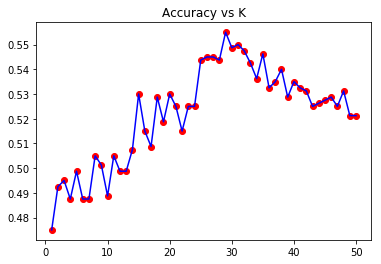

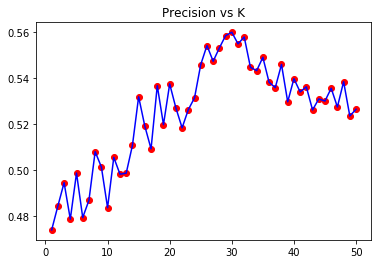

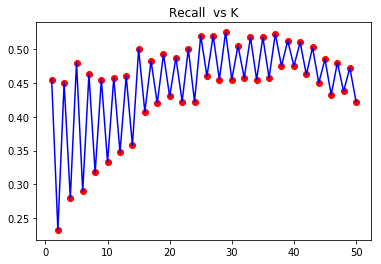

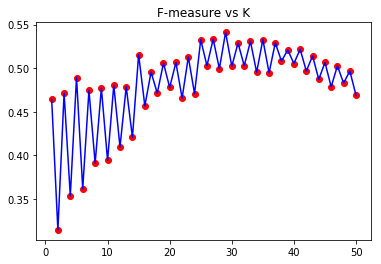

Maximum F-measure at K =  29
Accuracy :  0.555
Precision :  0.5585106382978723
Recall :  0.525
F-Measure :  0.5412371134020618


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot results
x_axis = [i for i in range(1, k+1)]

plt.plot(x_axis, a_list, 'ro')
plt.plot(x_axis, a_list, 'b-')
plt.title("Accuracy vs K")
plt.show()

plt.plot(x_axis, p_list, 'ro')
plt.plot(x_axis, p_list, 'b-')
plt.title("Precision vs K")
plt.show()

plt.plot(x_axis, r_list, 'ro')
plt.plot(x_axis, r_list, 'b-')
plt.title("Recall  vs K")
plt.show()

plt.plot(x_axis, f_list, 'ro')
plt.plot(x_axis, f_list, 'b-')
plt.title("F-measure vs K")
plt.show()

idx = np.argmax(f_list)
print("Maximum F-measure at K = ", idx+1)
print("Accuracy : ", a_list[idx])
print("Precision : ", p_list[idx])
print("Recall : ", r_list[idx])
print("F-Measure : ", f_list[idx])

GDA performed much better than k-NN. The F-measure of GDA was 0.947 where F-measure of k-NN was 0.541 at its best K. From the graph above, we can observe that the odd value of K is better than the even value of K. This could be happening since when K is even, it is k-NN could see equal number of classes, thus, it has to guess in this case. In addition, as the K increases, the fluctuation of F-measure decreased.

---
### Q4 - Generate synthetic dataset - DS2

In [8]:
import os
import random
import numpy as np
import pandas as pd 

data_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'Datasets')

''' Generate synthetic dataset '''
def q4():
    # read var
    cov1 = np.genfromtxt(os.path.join(data_dir, 'DS2_Cov1.txt'), delimiter=',')[:,:-1]
    cov2 = np.genfromtxt(os.path.join(data_dir, 'DS2_Cov2.txt'), delimiter=',')[:,:-1]
    cov3 = np.genfromtxt(os.path.join(data_dir, 'DS2_Cov3.txt'), delimiter=',')[:,:-1]
    
    neg1 = np.genfromtxt(os.path.join(data_dir, 'DS2_c2_m1.txt'), delimiter=',')[:-1]
    neg2 = np.genfromtxt(os.path.join(data_dir, 'DS2_c2_m2.txt'), delimiter=',')[:-1]
    neg3 = np.genfromtxt(os.path.join(data_dir, 'DS2_c2_m3.txt'), delimiter=',')[:-1]
    
    pos1 = np.genfromtxt(os.path.join(data_dir, 'DS2_c1_m1.txt'), delimiter=',')[:-1]
    pos2 = np.genfromtxt(os.path.join(data_dir, 'DS2_c1_m2.txt'), delimiter=',')[:-1]
    pos3 = np.genfromtxt(os.path.join(data_dir, 'DS2_c1_m3.txt'), delimiter=',')[:-1]
    
    # generate 2000 samples
    neg_s = genSample(cov1, cov2, cov3, neg1, neg2, neg3, -1)
    pos_s = genSample(cov1, cov2, cov3, pos1, pos2, pos3, 1)
    
    # split the data to test, valid and train set 
    neg_test, neg_valid, neg_train = splitSet(neg_s)
    pos_test, pos_valid, pos_train = splitSet(pos_s)
    
    # build data set
    data_set = np.concatenate((neg_s, pos_s))
    test_set = np.concatenate((neg_test, pos_valid))
    valid_set = np.concatenate((neg_valid, pos_valid))
    train_set = np.concatenate((neg_train, pos_train))
    
    # save data to csv
    write2csv(data_set, data_dir, 'DS2.csv')
    write2csv(test_set, data_dir, 'DS2_test.csv')
    write2csv(valid_set, data_dir, 'DS2_valid.csv')
    write2csv(train_set, data_dir, 'DS2_train.csv')
    
    return test_set, valid_set, train_set

''' generate n samples with given covariance and mean, last col will be filled with label '''
def genSample(cov1, cov2, cov3, mean1, mean2, mean3, label, sample_num=2000, feat_num=20):
    sample = np.empty([sample_num, feat_num])
    
    # for each row, generate samples with given covariance and mean
    for i in range(sample_num):
        rnd = random.random()
        #  probabilities = 0.1, 0.42, 0.48
        if rnd < 0.1:
            sample[i] = np.random.multivariate_normal(mean1, cov1).T
        elif rnd >=0.1 and rnd < 0.52:
            sample[i] = np.random.multivariate_normal(mean2, cov2).T
        else:
            sample[i] = np.random.multivariate_normal(mean3, cov3).T
            
    # append label at the last row
    labels = np.full((sample_num, 1), label, dtype=int)
    sample = np.append(sample, labels, axis=1)
    return sample

''' split data with given ratio '''
def splitSet(data_set, ratio=0.2):
    n_points = int(len(data_set)*ratio)
    np.random.shuffle(data_set)
    # n points for test and valid set 
    test, valid, train = data_set[:n_points], data_set[n_points:n_points*2], data_set[n_points*2:]
    
    return test, valid, train
    
''' write a numpy array to csv file '''
def write2csv(np_array, path, f_name):
    full_path = os.path.join(path, f_name)
    df = pd.DataFrame(np_array)
    df.to_csv(full_path, header=None, index=None)


In [9]:
user = input("generate new dataset? (y/n): ")
if user == 'y':
    test_set, valid_set, train_set = q4()
else: 
    print("Reading dataset from csv files...")
    data_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'Datasets')
    test_set = np.genfromtxt(os.path.join(data_dir, 'DS2_test.csv'), delimiter=',')
    valid_set = np.genfromtxt(os.path.join(data_dir, 'DS2_valid.csv'), delimiter=',')
    train_set = np.genfromtxt(os.path.join(data_dir, 'DS2_train.csv'), delimiter=',')

generate new dataset? (y/n): y


---
### Q5 - repeat Q2, Q3 with DS2 dataset

In [10]:
data_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'Datasets')

''' logistic sigmoid function '''
def sigmoid(a):
    return 1/(1+np.exp(-a))

''' generate w, w0 from dataset'''
def GDA(train_set):
    # separate train set
    neg_train = train_set[:len(train_set)//2,:-1]
    pos_train = train_set[len(train_set)//2:,:-1]

    # equal number of samples in neg/pos set, thus p = 0.5
    p0, p1 = 0.5, 0.5
    n0, n1 = neg_train.shape[0], pos_train.shape[0]

    # mean
    u0 = np.mean(neg_train, axis=0)
    u1 = np.mean(pos_train, axis=0)
    
    # get s0, s1, and sigma
    s0 = np.dot( (neg_train - u0).T, (neg_train - u0) ) / n0
    s1 = np.dot( (pos_train - u1).T, (pos_train - u1) ) / n1
    sigma = s0*n0/(n0+n1) + s1*n1/(n0+n1)
    
    # get w and w0
    w = np.linalg.inv(sigma).dot(u0-u1)
    w0 = -0.5*(u0.T.dot(np.linalg.inv(sigma)).dot(u0)) + 0.5*(u1.T.dot(np.linalg.inv(sigma)).dot(u1)) + np.log(p0/p1)

    return w, w0

''' compute probability '''
def predict(w, w0, x):
    p = sigmoid(w.dot(x.T) + w0)
    p = np.where(p<0.5, 1, -1)  # p below 0.5 is set to 1, else -1
    return p


In [11]:
train_set = np.genfromtxt(os.path.join(data_dir, 'DS2_train.csv'), delimiter=',')
test_set = np.genfromtxt(os.path.join(data_dir, 'DS2_test.csv'), delimiter=',')

w, w0 = GDA(train_set)
p = predict(w, w0, test_set[:,:-1])

# true negative, false positive, true positive, false negative
tn = (p[:len(p)//2] == -1).sum()
fp = (p[:len(p)//2] == 1).sum()
tp = (p[len(p)//2:] == 1).sum()
fn = (p[len(p)//2:] == -1).sum()

# get result
accuracy = (tn+tp) / (tn+fn+tp+fp)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
Fmeasure = (2*precision*recall) / (precision+recall)

print("Result:")
print("Accuracy : ", accuracy)
print("Precision : ", precision)
print("Recall : ", recall)
print("F-Measure : ", Fmeasure)
print("w: ", w)
print("w0: ", w0)

Result:
Accuracy :  0.5025
Precision :  0.5023809523809524
Recall :  0.5275
F-Measure :  0.5146341463414634
w:  [ 0.0045787   0.02589664 -0.06544508  0.00452959  0.07579685 -0.06502071
 -0.02447835  0.02418647  0.06598593  0.05468122  0.00095463  0.0451223
  0.06159283  0.00767271 -0.0596092  -0.01967507  0.01331553 -0.01986552
 -0.04425844 -0.02098485]
w0:  -0.0670655242635281


In [12]:
import numpy as np

def euclideanDistance(p1, dataset, labels):
    dists = []
    idx = 0
    for p2, l in zip(dataset, labels):
        # store (index, distance, label)
        d = np.sum((p1 - p2) ** 2)**0.5
        dists.append( (idx, d, l) )
    return dists

def kNN(train_set, test_set, k):
    labels = train_set[:,-1:]
    
    dists = []
    for sample in test_set[:,:-1]:
        dists.append( euclideanDistance(sample, train_set[:,:-1], labels) )

    prediction = []
    for i in range(k):
        temp = []
        for sample in dists:
            sample.sort(key=lambda tup: tup[1]) 
            p = np.mean(sample[:i+1], axis=0)[2]
            if p > 0:
                temp.append(1)
            else:
                temp.append(-1)
        prediction.append(temp)
    
    return np.array(prediction)


In [13]:
# read dataset
train_set = np.genfromtxt(os.path.join(data_dir, 'DS2_train.csv'), delimiter=',')
test_set = np.genfromtxt(os.path.join(data_dir, 'DS2_test.csv'), delimiter=',')

k = 50
pre = kNN(train_set, test_set, k)

print("Result:")

a_list, p_list, r_list, f_list = [], [], [], []
for i, p in enumerate(pre, 1):    
    # true negative, false positive, true positive, false negative
    tn = (p[:len(p)//2] == -1).sum()
    fp = (p[:len(p)//2] == 1).sum()
    tp = (p[len(p)//2:] == 1).sum()
    fn = (p[len(p)//2:] == -1).sum()

    # get result
    accuracy = (tn+tp) / (tn+fn+tp+fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    Fmeasure = (2*precision*recall) / (precision+recall)
    print("--------------------------------")
    print("K = ", i)
    print("Accuracy : ", accuracy)
    print("Precision : ", precision)
    print("Recall : ", recall)
    print("F-Measure : ", Fmeasure)
    
    
    a_list.append(accuracy)
    p_list.append(precision)
    r_list.append(recall)
    f_list.append(Fmeasure)  


Result:
--------------------------------
K =  1
Accuracy :  0.53375
Precision :  0.5323741007194245
Recall :  0.555
F-Measure :  0.543451652386781
--------------------------------
K =  2
Accuracy :  0.5275
Precision :  0.5523809523809524
Recall :  0.29
F-Measure :  0.380327868852459
--------------------------------
K =  3
Accuracy :  0.5225
Precision :  0.5226130653266332
Recall :  0.52
F-Measure :  0.5213032581453634
--------------------------------
K =  4
Accuracy :  0.5375
Precision :  0.5604838709677419
Recall :  0.3475
F-Measure :  0.4290123456790123
--------------------------------
K =  5
Accuracy :  0.5125
Precision :  0.5125
Recall :  0.5125
F-Measure :  0.5125
--------------------------------
K =  6
Accuracy :  0.53
Precision :  0.5422535211267606
Recall :  0.385
F-Measure :  0.45029239766081874
--------------------------------
K =  7
Accuracy :  0.52375
Precision :  0.5240506329113924
Recall :  0.5175
F-Measure :  0.5207547169811321
--------------------------------
K =  8
Acc

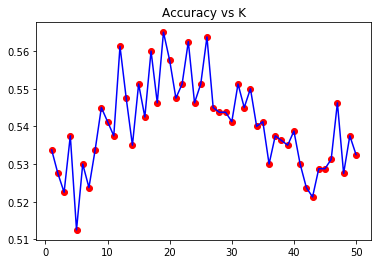

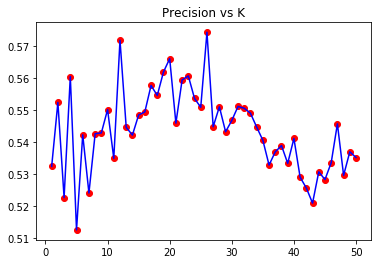

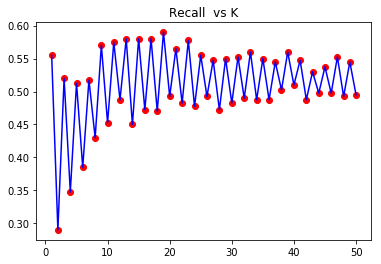

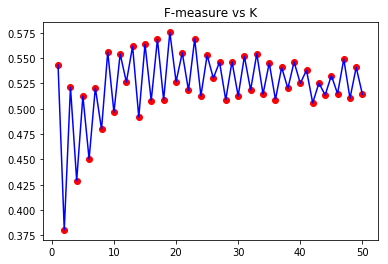

Maximum F-measure at K =  19
Accuracy :  0.565
Precision :  0.5619047619047619
Recall :  0.59
F-Measure :  0.5756097560975609


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot results
x_axis = [i for i in range(1, k+1)]

plt.plot(x_axis, a_list, 'ro')
plt.plot(x_axis, a_list, 'b-')
plt.title("Accuracy vs K")
plt.show()

plt.plot(x_axis, p_list, 'ro')
plt.plot(x_axis, p_list, 'b-')
plt.title("Precision vs K")
plt.show()

plt.plot(x_axis, r_list, 'ro')
plt.plot(x_axis, r_list, 'b-')
plt.title("Recall  vs K")
plt.show()

plt.plot(x_axis, f_list, 'ro')
plt.plot(x_axis, f_list, 'b-')
plt.title("F-measure vs K")
plt.show()

idx = np.argmax(f_list)
print("Maximum F-measure at K = ", idx+1)
print("Accuracy : ", a_list[idx])
print("Precision : ", p_list[idx])
print("Recall : ", r_list[idx])
print("F-Measure : ", f_list[idx])

For this dataset, k-NN performed better than GDA. GDA’s accuracy significantly dropped to 0.5 which is simply same as guessing yes or no. <br>
k-NN had its best performance at K=19, which is odd value similar to the value achieved at Question 3. Again, as show in the graph, as the K increases, the fluctuation of F-measure decrease.

---
### Q6

When the classes were generated with one Gaussian (i.e. DS1), GDA showed excellent performance but when the classes were generated with multiple Gaussians (i.e. DS2), the overall performance dropped significantly. On the other hand, k-NN had similar performance for both datasets. This indicates that GDA is highly sensitive to probability distribution of the input data, but k-NN is not.